In [1]:
import numpy as np
import pandas as pd

import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

import pickle

2023-06-20 20:53:02.556998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('../data/processed/subset_with_augs.csv')
data.head()

,chart_type,source,data_series,path,name
0,line,generated,"[{'x': '0', 'y': 25.132480533926586}, {'x': '1...",../data/raw/train/images/6274f182ba84.jpg,6274f182ba84
1,line,generated,"[{'x': '1990', 'y': 1594.7404572662153}, {'x':...",../data/raw/train/images/ebed9672f05e.jpg,ebed9672f05e
2,line,generated,"[{'x': 'Jan', 'y': 19.252781561026715}, {'x': ...",../data/raw/train/images/1df6f427d037.jpg,1df6f427d037
3,line,generated,"[{'x': 'Jan', 'y': 13.177213920369073}, {'x': ...",../data/raw/train/images/6b7f05a54ba9.jpg,6b7f05a54ba9
4,line,generated,"[{'x': 'Fiji', 'y': 31.651786659948677}, {'x':...",../data/raw/train/images/0e22a3b55726.jpg,0e22a3b55726


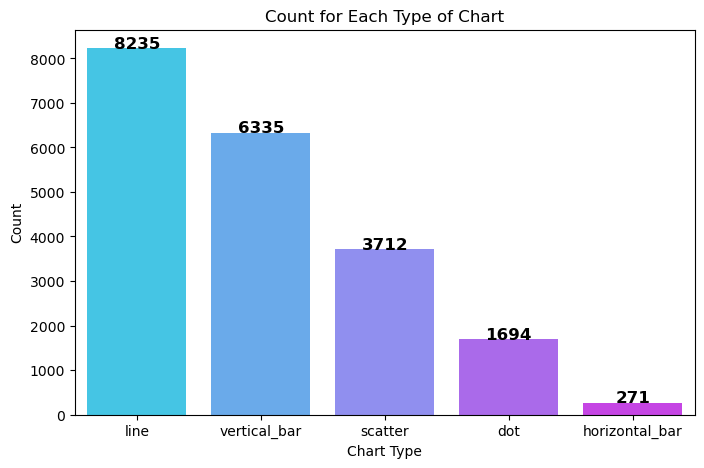

In [3]:
plt.figure(figsize=(8,5))

ax = sns.countplot(x='chart_type', data=data, palette='cool')

ax.set_ylabel('Count')
ax.set_xlabel('Chart Type')
ax.set_title('Count for Each Type of Chart')
for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-0.4, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='large') 
        
plt.show()

In [4]:
img_list = list(data['path'])
data_img = []
for img in img_list:
               #Read each image:
               each_img = cv2.imread(img)
               #OpenCv default color is BGR. Convert it to RGB:
               each_img = cv2.cvtColor(each_img, cv2.COLOR_BGR2RGB)
               #Resize the images:
               each_img_resized = cv2.resize(each_img, (256,256))
               #Save arrays to a list:
               data_img.append(each_img_resized)
# Converting list to numpy array
X = np.array(data_img)

print('Shape of X: ', X.shape)

Shape of X:  (20247, 256, 256, 3)


In [5]:
labelencoder=LabelEncoder()
y = to_categorical(labelencoder.fit_transform(data['chart_type']))
print('Shape of y:', y.shape)

Shape of y: (20247, 5)


In [6]:
labels = list(labelencoder.classes_)
labels

['dot', 'horizontal_bar', 'line', 'scatter', 'vertical_bar']

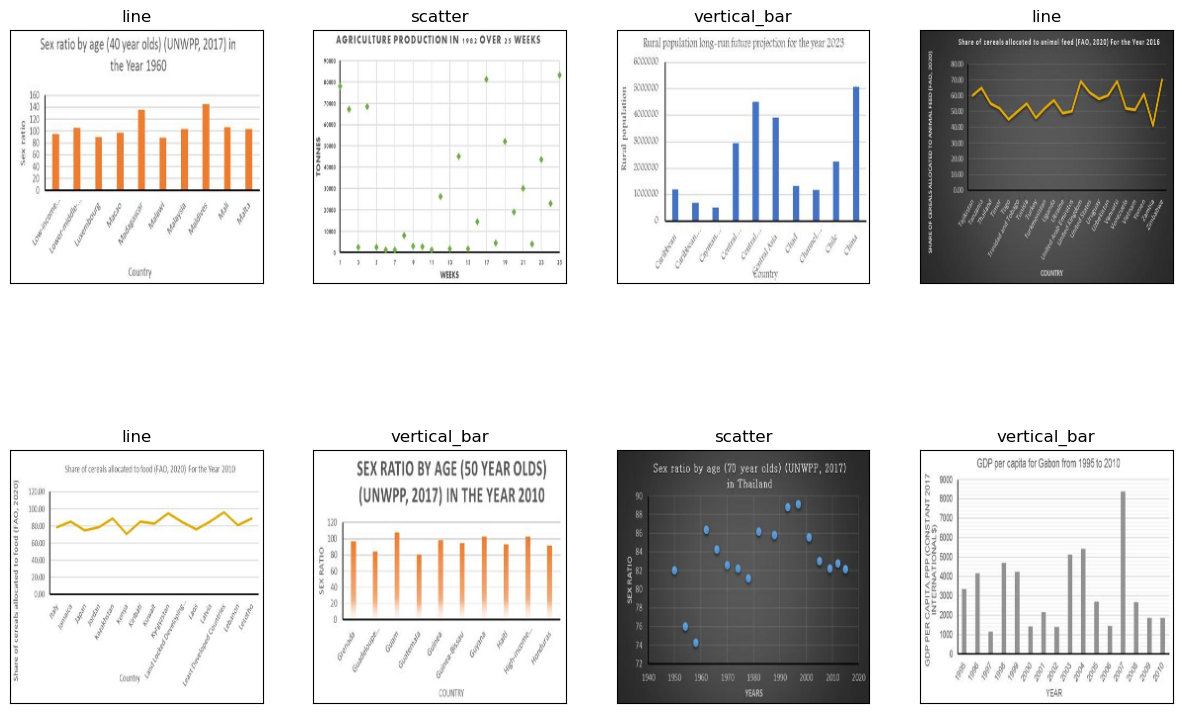

In [7]:
indices = np.random.randint(0,20000,8)
i = 1
plt.figure(figsize=(15,10))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(data['chart_type'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [9]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (13767, 256, 256, 3)
y_train shape:  (13767, 5)
X_val shape  :  (3442, 256, 256, 3)
y_val shape  :  (3442, 5)
X_test shape :  (3038, 256, 256, 3)
y_test shape :  (3038, 5)


In [10]:
# Neural Network
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [11]:
model.compile('adam', loss='categorical_crossentropy',metrics='accuracy')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
hist = model.fit(X_train, y_train, validation_data=[X_val,y_val], epochs=5)

Epoch 1/5
431/431 [==============================] - 670s 2s/step - loss: 6.9239 - accuracy: 0.8080 - val_loss: 0.2123 - val_accuracy: 0.9332
Epoch 2/5
431/431 [==============================] - 632s 1s/step - loss: 0.1676 - accuracy: 0.9447 - val_loss: 0.1022 - val_accuracy: 0.9646
Epoch 3/5
431/431 [==============================] - 623s 1s/step - loss: 0.1943 - accuracy: 0.9395 - val_loss: 0.1986 - val_accuracy: 0.9396
Epoch 4/5
431/431 [==============================] - 610s 1s/step - loss: 0.1888 - accuracy: 0.9362 - val_loss: 0.1323 - val_accuracy: 0.9637
Epoch 5/5
431/431 [==============================] - 627s 1s/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.0823 - val_accuracy: 0.9770


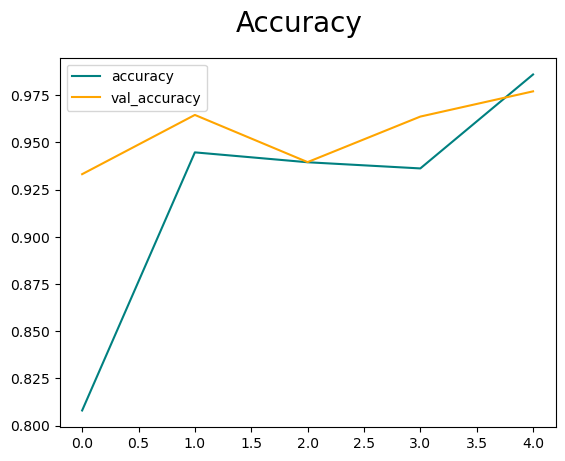

In [ ]:
# Plot the accuracy of the model
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

95/95 [==============================] - 43s 446ms/step


In [ ]:
y_pred = np.argmax(y_pred,axis=1)
y_pred = labelencoder.inverse_transform(y_pred) 

y_test_labels = np.argmax(y_test, axis=1)
y_test_labels = labelencoder.inverse_transform(y_test_labels) 

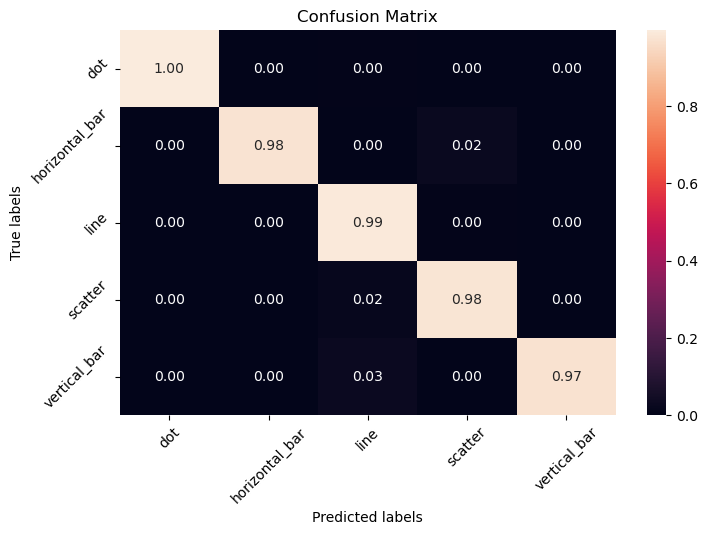

In [ ]:
cm = confusion_matrix(y_test_labels, y_pred, normalize='true', labels=labels)

plt.figure(figsize=(8,5))
ax = sns.heatmap(cm, annot=True, fmt='.2f')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels) 
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pickle.dump(model, open('../models/subset_with_augs_model.pkl','wb'))